# **Adult Income Prediction**


# Import necessary libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, roc_auc_score, RocCurveDisplay)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import shap

from sklearn.metrics import f1_score


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Data Ingestion & Cleaning

In [ ]:
github_url = "https://raw.githubusercontent.com/gopikantm/IncomePrediction/refs/heads/main/adult_income_data.csv"

try:
    data = pd.read_csv(github_url, na_values=' ?', skipinitialspace=True)

    column_names = [
        'Age', 'Workclass', 'fnlwgt', 'Education', 'Education-num',
        'Marital-Status', 'Occupation', 'Relationship', 'Race', 'Sex',
        'Capital-Gain', 'Capital-Loss', 'Hours-per-week', 'Native-Country', 'Income'
    ]
    data.columns = column_names

    print("Data loaded successfully with shape:", data.shape)

except Exception as e:
    print(f"Error loading data: {e}")

Data loaded successfully with shape: (32560, 15)


In [ ]:
df = pd.DataFrame(data)
df.head()

,Age,Workclass,fnlwgt,Education,Education-num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-per-week,Native-Country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [ ]:
# Handle missing values properly to preserve data types
df = df.replace('?', np.nan)

# Fill missing values differently for numerical vs categorical columns
# First identify numerical columns (excluding target variable)
numerical_cols = ['Age', 'fnlwgt', 'Education-num', 'Capital-Gain', 'Capital-Loss', 'Hours-per-week']
categorical_cols = ['Workclass', 'Education', 'Marital-Status', 'Occupation',
                   'Relationship', 'Race', 'Sex', 'Native-Country', 'Income']

# Fill numerical columns with median
for col in numerical_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

# Fill categorical columns with 'Missing'
for col in categorical_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna('Missing')

# Verify data types
print("\nData types after cleaning:")
print(df.dtypes)


Data types after cleaning:
Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education-num      int64
Marital-Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital-Gain       int64
Capital-Loss       int64
Hours-per-week     int64
Native-Country    object
Income            object
dtype: object


In [ ]:
# Display basic info
print("\nFirst 5 rows:")
display(df.head())
print("\nDataset information:")
print(df.info())
print("\nMissing values per column:")
print(df.isna().sum())


First 5 rows:


,Age,Workclass,fnlwgt,Education,Education-num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-per-week,Native-Country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K



Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education-num   32560 non-null  int64 
 5   Marital-Status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital-Gain    32560 non-null  int64 
 11  Capital-Loss    32560 non-null  int64 
 12  Hours-per-week  32560 non-null  int64 
 13  Native-Country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None

Missing values per column:
Age               0
Workclass         

# Exploratory Data Analysis (EDA)

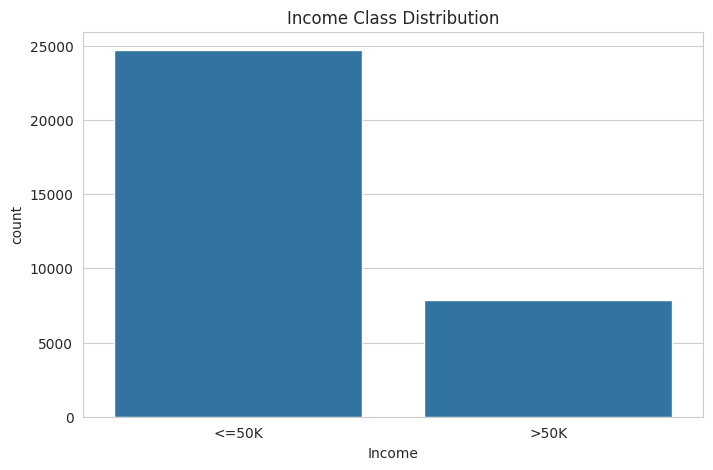

In [ ]:
# 1. Class distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Income')
plt.title('Income Class Distribution')
plt.show()

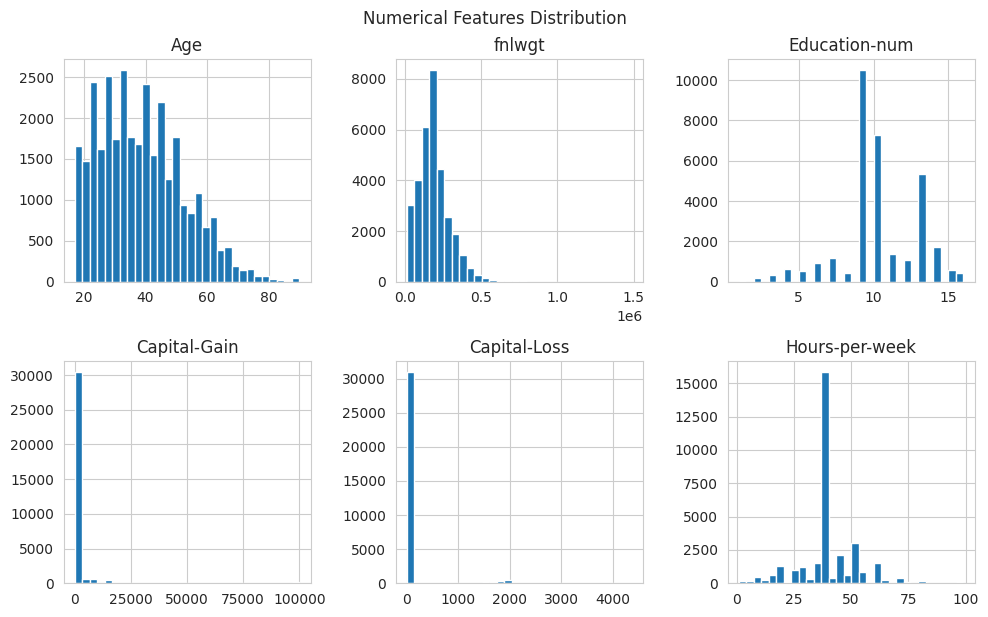

In [ ]:
# 2. Numerical features distribution
num_cols = ['Age', 'fnlwgt', 'Education-num', 'Capital-Gain', 'Capital-Loss', 'Hours-per-week']
df[num_cols].hist(bins=30, layout=(2, 3))
plt.tight_layout()
plt.suptitle('Numerical Features Distribution', y=1.02)
plt.show()

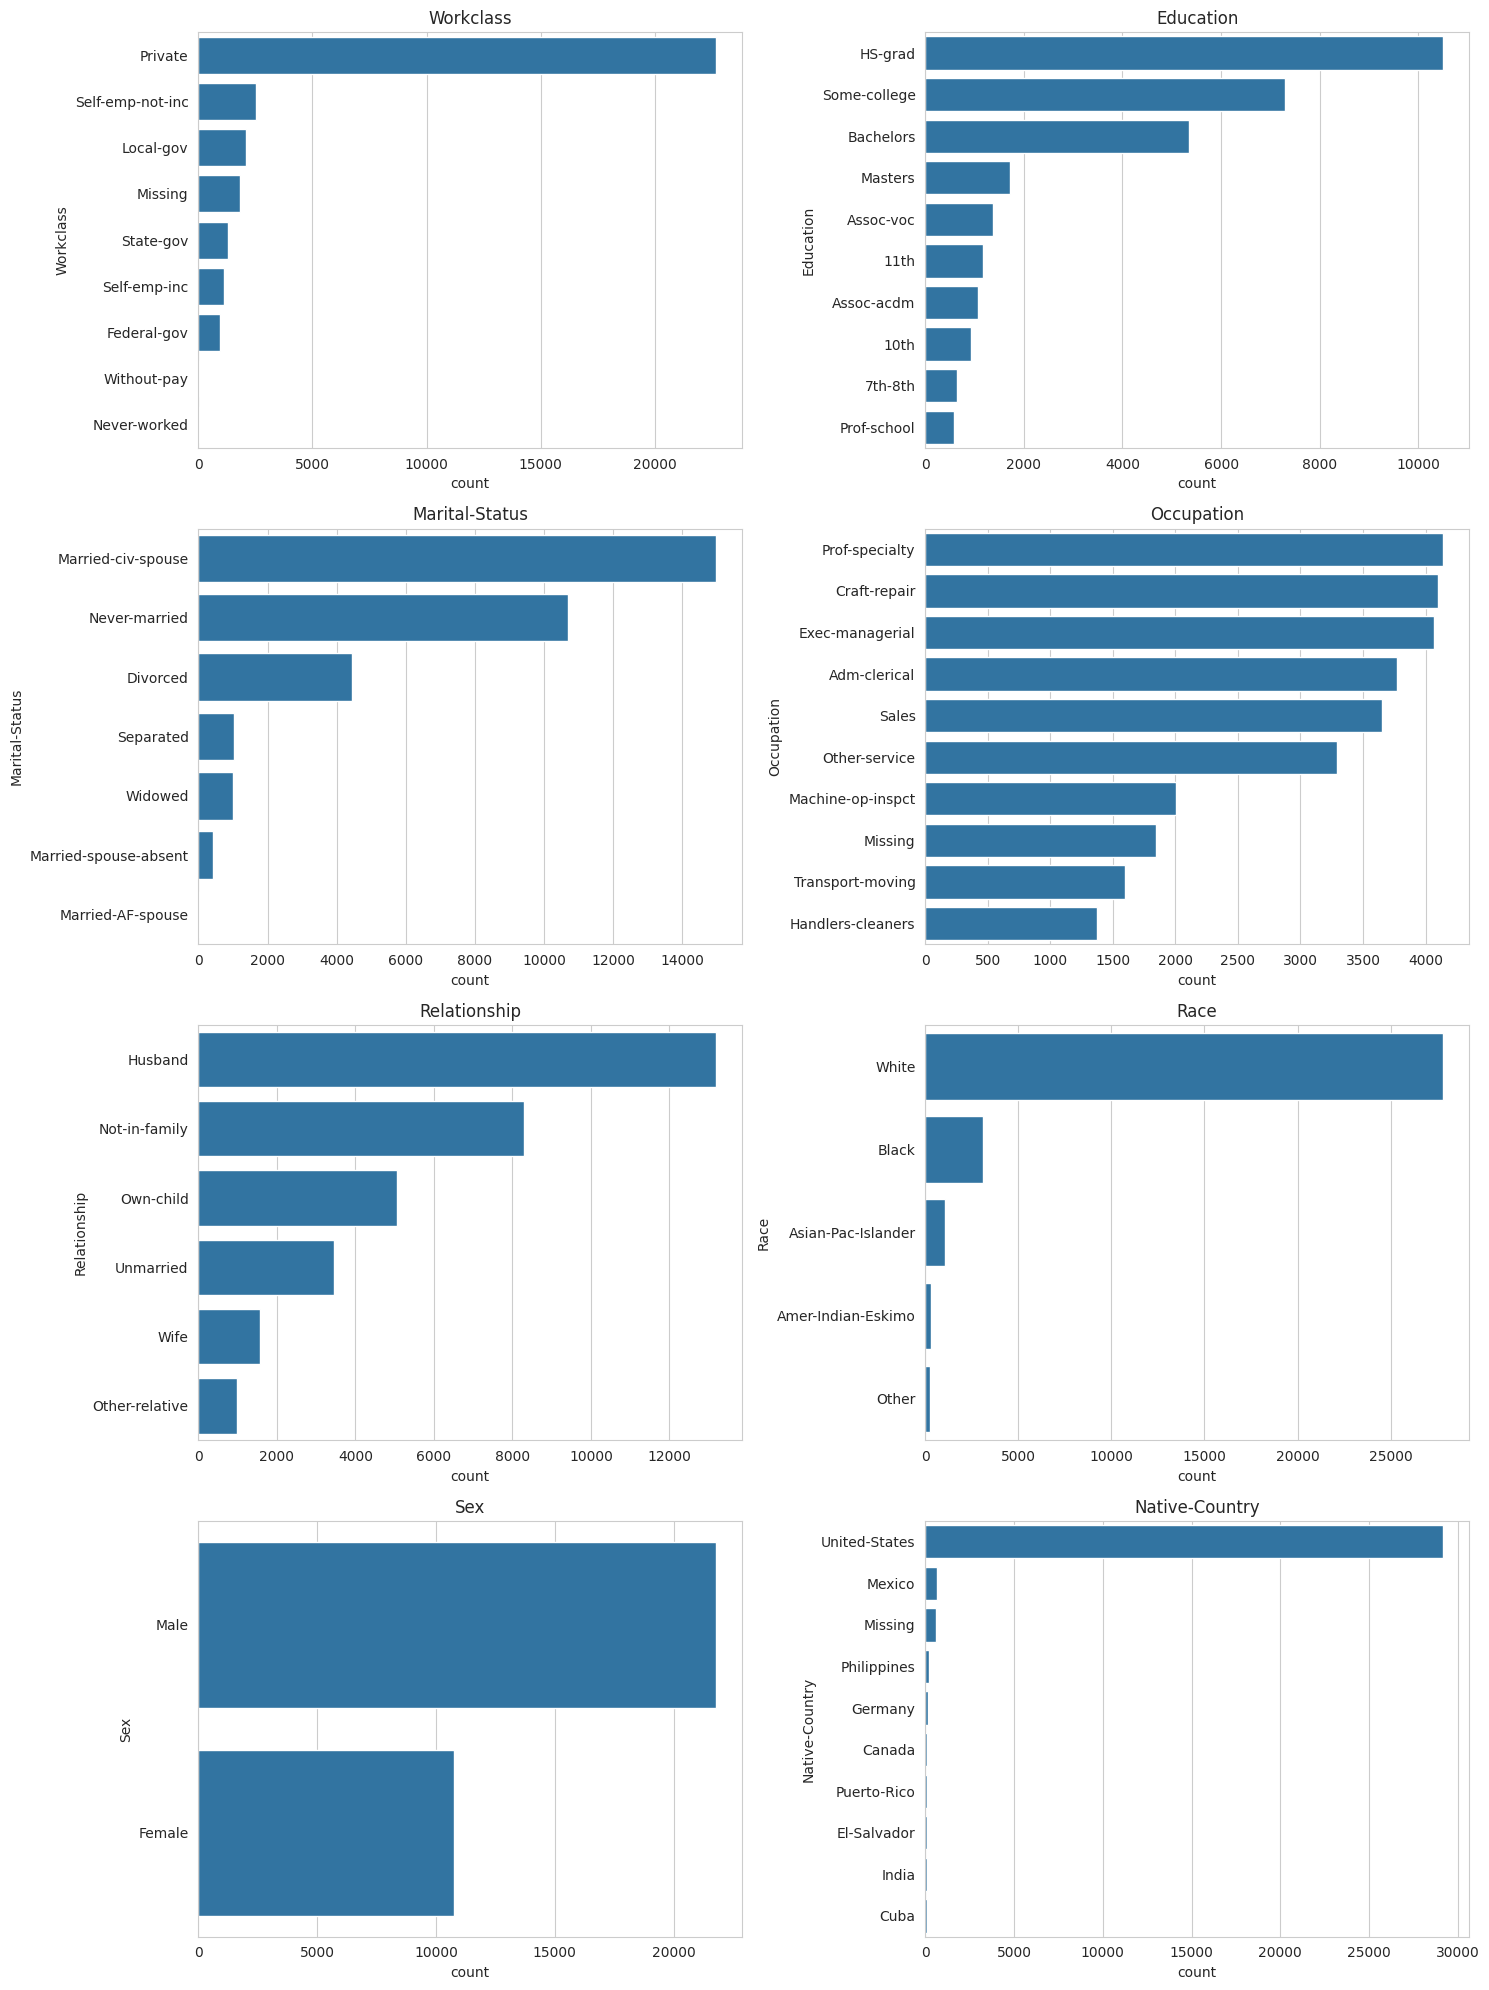

In [ ]:
# 3. Categorical features
cat_cols = ['Workclass', 'Education', 'Marital-Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native-Country']

plt.figure(figsize=(15, 20))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(4, 2, i)
    sns.countplot(data=df, y=col, order=df[col].value_counts().index[:10])
    plt.title(col)
plt.tight_layout()
plt.show()

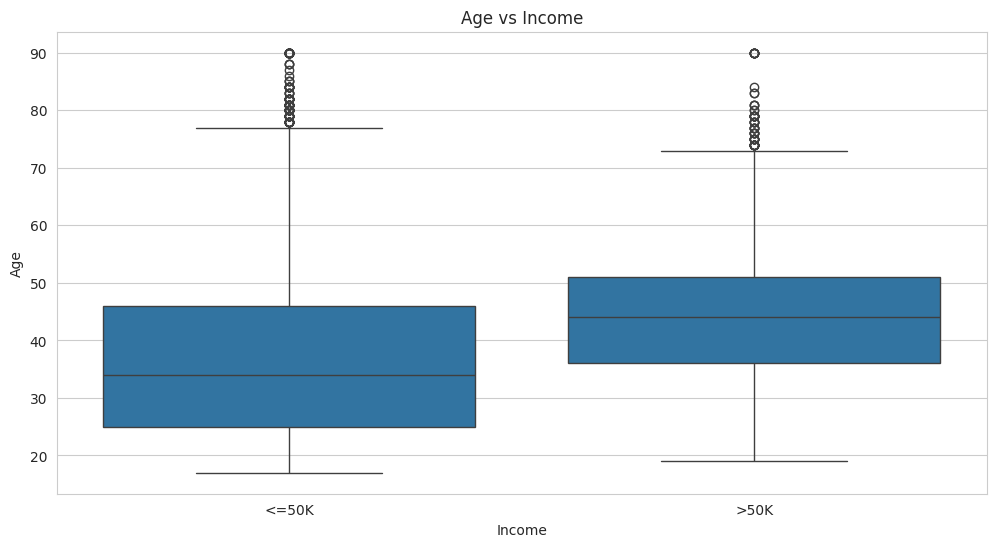

In [ ]:
# 4. Relationships with target
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Income', y='Age')
plt.title('Age vs Income')
plt.show()

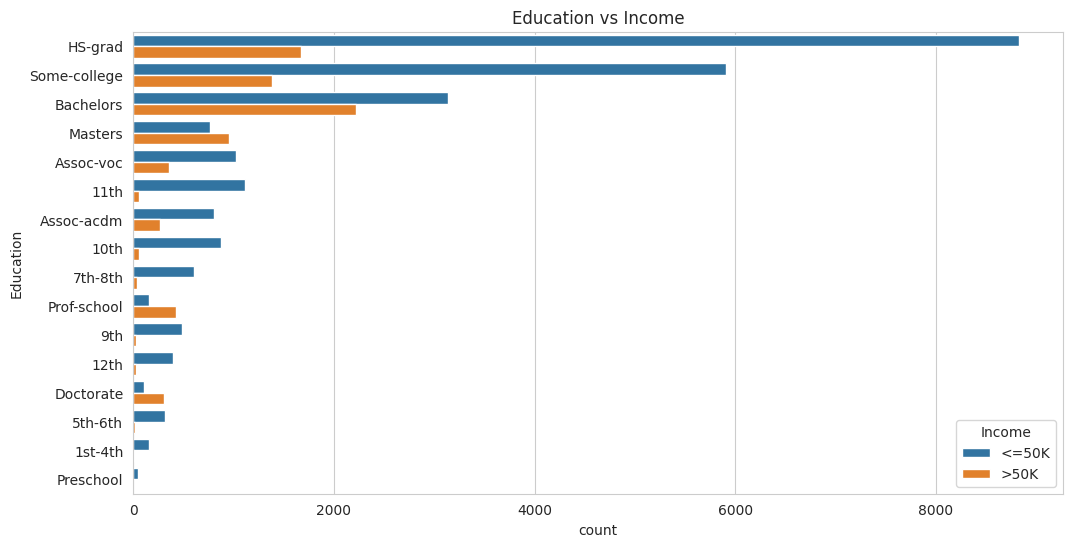

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Education', hue='Income', order=df['Education'].value_counts().index)
plt.title('Education vs Income')
plt.show()

# Feature Engineering & Preprocessing

In [ ]:
# Create new features
df['Capital-Total'] = df['Capital-Gain'] - df['Capital-Loss']
df['Age-Group'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 55, 65, 100],
                        labels=['<25', '25-35', '35-45', '45-55', '55-65', '65+'])

df.head()

,Age,Workclass,fnlwgt,Education,Education-num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-per-week,Native-Country,Income,Capital-Total,Age-Group
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0,45-55
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0,35-45
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0,45-55
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0,25-35
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,0,35-45


In [ ]:
# Update feature lists
num_cols.extend(['Capital-Total'])
cat_cols.append('Age-Group')

In [ ]:
# Split data
X = df.drop('Income', axis=1)
y = df['Income'].apply(lambda x: 1 if x == '>50K' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Preprocessing pipelines
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

In [ ]:
# Full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Model Training & Evaluation

In [ ]:
# Define models and parameters
models = {
    'Logistic Regression': {
        'classifier': [LogisticRegression(max_iter=1000, random_state=42)],  # Note the list
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l2']
    },
    'Random Forest': {
        'classifier': [RandomForestClassifier(random_state=42)],  # Note the list
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5]
    },
    'XGBoost': {
        'classifier': [XGBClassifier(random_state=42, eval_metric='logloss')],  # Note the list
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 6, 9],
        'classifier__learning_rate': [0.01, 0.1]
    }
}

In [ ]:
# Train and evaluate models

results = []
for name, params in models.items():
    print(f"\nTraining {name}...")

    # Update pipeline with current model's parameters
    pipeline.set_params(**{'classifier': params['classifier'][0]})

    # Create GridSearchCV
    grid = GridSearchCV(
        pipeline,
        param_grid=params,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    # Evaluate
    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1]

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': accuracy_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba),
        'F1': f1_score(y_test, y_pred)
    })

    print(f"{name} best score: {grid.best_score_:.4f}")
    print(classification_report(y_test, y_pred))


Training Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Logistic Regression best score: 0.9091
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4944
           1       0.76      0.61      0.68      1568

    accuracy                           0.86      6512
   macro avg       0.82      0.78      0.80      6512
weighted avg       0.86      0.86      0.86      6512


Training Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Random Forest best score: 0.9163
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      4944
           1       0.81      0.60      0.69      1568

    accuracy                           0.87      6512
   macro avg       0.84      0.78      0.80      6512
weighted avg       0.86      0.87      0.86      6512


Training XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
XGBoost bes

In [ ]:
# Display results
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
display(results_df.sort_values('ROC AUC', ascending=False))


Model Comparison:


,Model,Best Params,Accuracy,ROC AUC,F1
2,XGBoost,"{'classifier': XGBClassifier(base_score=None, ...",0.880221,0.934879,0.728790
1,Random Forest,{'classifier': RandomForestClassifier(random_s...,0.869625,0.925036,0.690710
0,Logistic Regression,{'classifier': LogisticRegression(max_iter=100...,0.861333,0.916943,0.680806


<ipython-input-48-723b653b8ec7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='ROC AUC', palette='viridis')


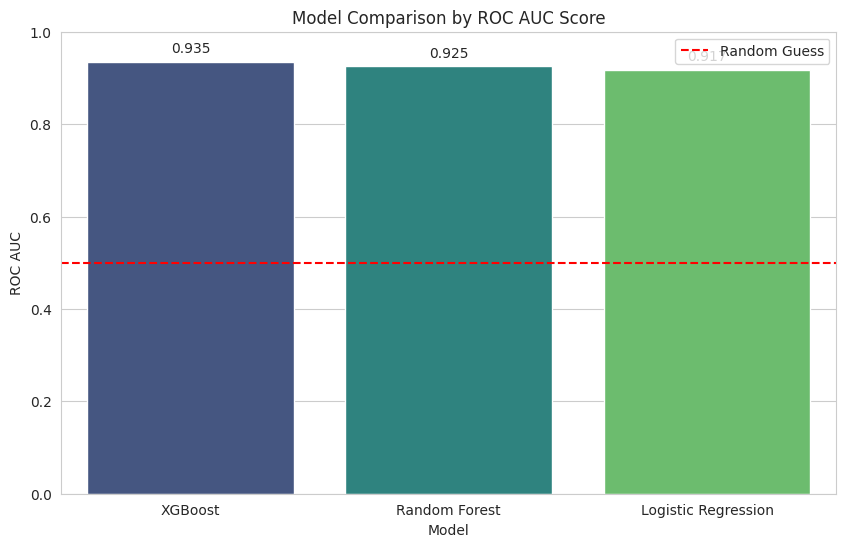

In [ ]:
# Sort results by ROC AUC
results_df = results_df.sort_values('ROC AUC', ascending=False)

# Create comparison bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='ROC AUC', palette='viridis')
plt.title('Model Comparison by ROC AUC Score')
plt.ylim(0, 1)
plt.axhline(y=0.5, color='red', linestyle='--', label='Random Guess')
plt.legend()
for i, v in enumerate(results_df['ROC AUC']):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')
plt.show()